In [2]:
import random; random.seed(0)
import numpy as np; np.random.seed(0)
import torch; torch.manual_seed(0)

from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm
from pathlib import Path

import einops, umap, os
from sklearn.metrics import silhouette_score, silhouette_samples

import seaborn as sns; sns.set()

batch_size = 128

/home/labadier/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/labadier/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/labadier/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarni

## Dataset

For our project we rely on the Cifar-10 dataset, which consists on examples of images with size 32x32 in rgb channels. To evaluate the studied approaches we use the torchvision library which contains the latter dataset splited into training and dev in a balanced fashion accross all its 10 classes, resulting in 50K examples for training and 10K for develompent.

Since in this project we are looking for evaluate the performance of some feature selection techinques such as Autoencoders, we will construct a third split from the dev set (test) to evaluate in an unbiased way the models performance. The test set, will be constructed sampling ~100 instances of each class from the development set.

In [3]:
def load_dataset(batch_size: int = 64) -> tuple[DataLoader, DataLoader]:

    '''
        Load the MNIST dataset and return the train and dev dataloaders.
        batch_size: the batch size for the dataloaders iterators
    '''

    transform = transforms.Compose(
      [transforms.ToTensor(),
      ])

    train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader( train_data, batch_size=batch_size, shuffle=True )

    test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    val_data, test_data = torch.utils.data.random_split(test_data, [int(0.9*len(test_data)), int(0.1*len(test_data))])
    

    dev_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)    
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


    # convert dict to sorted list
    class_mapping = [ z[0] for z in sorted(list(train_data.class_to_idx.items()), key=lambda x: x[1])]

    return train_loader, dev_loader, test_loader, class_mapping

train_loader, dev_loader, test_loader, class_mapping = load_dataset(batch_size = batch_size)

Files already downloaded and verified
Files already downloaded and verified


(0.0, 15.0)

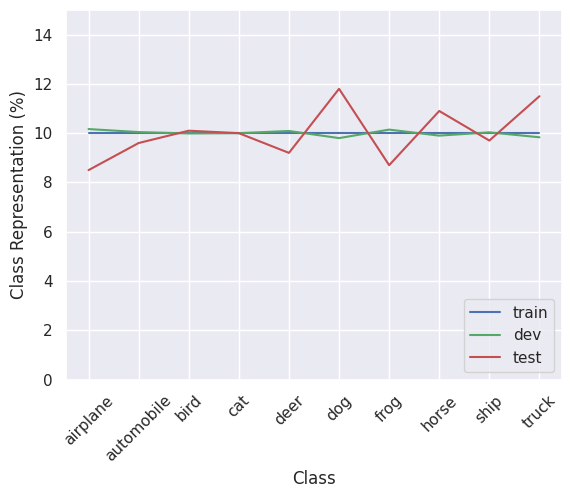

In [3]:
def get_relative_freqs(loader: DataLoader) -> list[float]:

    '''
        Return the relative frequencies of the classes in the dataset.
        loader: the dataloader to use
    '''

    freqs = [0] * 10
    for _, labels in loader:
        for label in labels:
            freqs[label.item()] += 1
    freqs = [freq*100 / sum(freqs) for freq in freqs]
    return freqs


fig, ax = plt.subplots()

ax.plot([i for i in get_relative_freqs(train_loader)], label='train', c='b', linestyle="-")
ax.plot([i for i in get_relative_freqs(dev_loader)], label='dev', c='g', linestyle="-")
ax.plot([i for i in get_relative_freqs(test_loader)], label='test',c='r', linestyle="-")
ax.legend( loc='lower right')
ax.set_ylabel('Class Representation (%)')
ax.set_xlabel('Class')

ax.set_xticks(np.arange(len(class_mapping)))
ax.set_xticklabels(class_mapping)

# Set x label rotation
plt.xticks(rotation=45)
plt.ylim(0, 15)

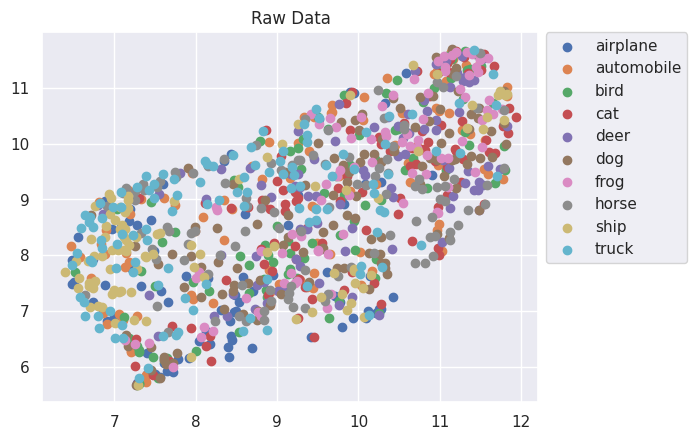

In [4]:
def plot_projection(loader: DataLoader, n_components: int, model: torch.nn.Module = None, source: str = 'Raw Data', reduction: str = 'umap' ) -> None:

    '''
        Plot the projection of the data in the dataloader using TSNE.
        
        loader: the dataloader to use
        n_components: the number of components to use in the projection
        source: the source of the data (used in the title)
        model: the model to use to project the data into a latent space (if None, the raw data is used)
        reduction: the reduction method to use (tsne or umap)

    '''

    example = []
    label = []
    for images, labels in loader:
        
        label += [labels.numpy()]
        
        if model is None:
            example += [images.view(images.shape[0], -1).numpy()]
        else:
            encoding = model(images.to(model.device), get_encoding=True).detach().cpu()
            example += [encoding.numpy()]
    
    example = np.concatenate(example, axis=0)
    label = np.concatenate(label)
    
    if example.shape[-1] > n_components:
        if reduction == 'tsne':
            t_sne = TSNE(n_components=n_components)
            example = t_sne.fit_transform(example)
        elif reduction == 'umap':
            reducer = umap.UMAP(n_neighbors = 50, min_dist=0.03)
            example = reducer.fit_transform(example)

    for clase in range(10):
        plt.scatter(example[label == clase, 0], example[label == clase, 1], label=class_mapping[clase])
    
    plt.legend()

    plt.legend(bbox_to_anchor=(1., 1.02))
    plt.title(source)
    plt.show()

plot_projection(test_loader, 2)

At this point we can see that projecting the raw representation of our data does not seems to depict any distance relation in the space of representation obtained when the image mappings are flattened into a vector.

We then try to use the idea introduced by the Autoencoders and PCA at first, which underlies on determining two functions $f$ and $g$, the encoder and decoder respectively. The firstone learns to maps the inputs of the model into a dense representation which contains a condensed transforation of it.
This lattent representation is interpolated back into the original space by the decoder function and compared to the input of the model to propagate the errors made by both  $f$ and $g$ by using gradient descent-like algorithm. 
This way of determining $f$ and $g$ used for iterative and learning process as in neural networks, whereas with PCA we have:  $g = f^{-1}$ and these transformation matrices are obtained with a basis of ortonormal vectors asociated to the absolutly greater aigenvalues of the covariance matrix of features.

In our case, $f$ and $g$ will be convolutional operator-based models. We must notice that in the simple cases of Autoencoders, the models are prone to overfit the training set since, overlooking the relation of hyper-vectors in the neighborhod of the latent representation of the training examples when decoding them, which is kown as space (Non-)Regularity.


In [6]:
def init_weights(module: torch.nn.Module) -> None:
    
    if isinstance(module, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
        
    elif isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

class EvidenceLowerBound(torch.nn.Module):

    def __init__(self) -> None:

        '''
            model: the model to use to compute the ELBO
            likelihood: the likelihood to use to compute the ELBO (bernoulli or gaussian)
        '''

        super(EvidenceLowerBound, self).__init__()
        

    def Kullback_Leibler_Divergence(self, z: torch.Tensor , mu: torch.Tensor, lvar: torch.Tensor) -> torch.Tensor:
        '''
            Computes the Kullback-Leibler divergence (Aproximation across samples of the batch) between a normal distribution with mean mu and variance
            std and a standard normal distribution, which is used to regularize the latent space by assuming our encoding is a sample from a 
            distribution rather than a single point.

            z: the latent representation.

            mu: the mean of the normal distribution
            std: the standard deviation of the normal distribution
        '''

        # p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(lvar))
        # q = torch.distributions.Normal(mu, torch.exp(0.5 * lvar))

        # kl = (q.log_prob(z) - p.log_prob(z)).sum(-1)
        
        std = torch.exp(0.5 * lvar)
        kl = torch.mean(-0.5 * torch.sum(1 + std - mu ** 2 - std.exp(), dim = 1), dim = 0)
  
        return kl.mean()

    def Decoder_posterior_probability(self, x: torch.Tensor, mu: torch.Tensor ) -> torch.Tensor:

        '''
            Computes the probability of the input x given the latent representation under with their correspondings parameters 
            estimated by the decoder (mean) and an scale which is shared accross all images distribution (to be maximized).
        '''

        rec_loss = torch.nn.functional.binary_cross_entropy(mu, x, reduction='none').sum(dim=(1, 2, 3)) #torch.nn.functional.mse_loss(x, mu, reduction='none').sum(dim=(1, 2, 3))
        return rec_loss
    
    def forward(self, x: torch.Tensor, outputs: tuple[torch.tensor, ...] ) -> torch.Tensor:
        '''
            Computes the ELBO of the model given the input x and the outputs of the model.
        '''

        mu, lvar, z, decoder_mu = outputs
        
        kl = self.Kullback_Leibler_Divergence(z, mu, lvar)
        rec_loss = self.Decoder_posterior_probability(x, decoder_mu).mean()
        
        return 0.01*kl + rec_loss, kl.detach(), rec_loss.detach()


class Encoder(torch.nn.Module):

    '''
        Encoder Module
        Applies a series of non-linear transformations to the input tensor to condense de information into a latent representation.
    '''

    def __init__(self, input_depth: int, hidden_dim: int) -> None:

        '''
            input_dim: amount of input features
            hidden_dim: rank of latent representation
        '''

        super(Encoder, self).__init__()

        self.input_dim = input_depth
        self.hidden_dim = hidden_dim

        self.encoder = torch.nn.Sequential( torch.nn.Conv2d(input_depth, 32, kernel_size=3, stride=2),
                                            torch.nn.ReLU(),
                                            #15x15 mapping
                                            
                                            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
                                            torch.nn.ReLU(),
                                            #7x7 mapping
                                            
                                            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2),
                                            torch.nn.ReLU(),
                                            #3x3 mapping
                                            
                                            torch.nn.Flatten(),
                                            torch.nn.Linear(3*3*128, hidden_dim)
        )

        self.mean_layer = torch.nn.Linear(hidden_dim, hidden_dim)
        self.var_layer = torch.nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        latent = self.encoder(x)
        mu = self.mean_layer(latent)
        var = self.var_layer(latent)

        return self.encoder(x), mu, var

class Decoder(torch.nn.Module):

    '''
            Decoder Module
            Applies a series of non-linear transformations to the latent representation to reconstruct the input tensor. 
            Based in transposed convolutions to usample the image encoded by th encoder until reach the same size as the input.
    ''' 
     

    def __init__(self, output_depth: int, hidden_dim: int) -> None:

        '''
            input_dim: amount of input features
            hidden_dim: rank of latent representation
        '''

        super(Decoder, self).__init__()

        self.input_dim = output_depth
        self.hidden_dim = hidden_dim
        
        self.un_lantent = torch.nn.Sequential(torch.nn.Linear(hidden_dim, 128*3*3), torch.nn.ReLU())

        self.decoder = torch.nn.Sequential( torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
                                            torch.nn.ReLU(),
                                            # 7x7 mapping
                                            
                                            torch.nn.ConvTranspose2d(64, 32, 3, padding=1),
                                            torch.nn.ReLU(),

                                            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
                                            torch.nn.ReLU(),
                                            
                                            # 15x15
                                            torch.nn.ConvTranspose2d(16, output_depth, kernel_size=3, stride=2, output_padding=1),
                                            torch.nn.Sigmoid(),

        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = self.un_lantent(x)
        x = einops.rearrange(x, 'b (c w h) -> b c w h', w = 3, h = 3)
        return self.decoder(x) 


class Autoencoder(torch.nn.Module):

    '''
        Autoencoder Module
        Combines the encoder and decoder modules to explore the family of f and g functions.
    '''

    def __init__(self, input_depth: int, hidden_dim: int) -> None:

        '''
            input_dim: amount of input features
            hidden_dim: rank of latent representation
        '''

        super().__init__()

        self.best_loss = None

        self.input_dim = input_depth
        self.hidden_dim = hidden_dim

        self.encoder = Encoder(input_depth, hidden_dim)
        self.decoder = Decoder(input_depth, hidden_dim)
        
        self.apply(init_weights)

        self.loss_criterion = EvidenceLowerBound()#torch.nn.MSELoss()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x: torch.Tensor, get_encoding: bool = False) -> torch.Tensor:
             
            encode, mu_latent, var_latent = self.encoder(x)

            if get_encoding:
                return encode
            
            std_latent = torch.exp(0.5 * var_latent) # log variance (con valores negativos) to std
            resampled_encode  = torch.randn_like(std_latent) * std_latent + mu_latent
            
            decode = self.decoder(resampled_encode)
            
            return mu_latent, var_latent, resampled_encode, decode
    
    def save(self, path: str) -> None:
        torch.save(self.state_dict(), path)

    def load(self, path: str) -> None:
        self.load_state_dict(torch.load(path, map_location=self.device))

    def make_optimizer(self, lr: float, epoches: int, steps_per_epoch) -> None:
        
        opt = torch.optim.Adam(self.parameters(), lr=lr)        
        return opt 
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [7]:
def train_model( trainloader: DataLoader, devloader: DataLoader, epoches: int, output: str, 
                latent_rank: int, lr: float) -> dict[str, list[float]]:


    Path(output).mkdir(parents=True, exist_ok=True)
    stats = {}

    model = Autoencoder(input_depth=3, hidden_dim=latent_rank)
    
    params_amount = sum([np.prod(param.shape) for param in model.parameters()])
    print('Total number of parameters: ', params_amount)

    optimizer = model.make_optimizer(lr=lr, epoches=epoches, steps_per_epoch = len(trainloader))

    for epoch in range(epoches):

        running_stats = { 'loss': 0., 'kl': 0., 'rec_loss': 0.}

        iter = tqdm(enumerate(trainloader, 0))
        iter.set_description(f'Epoch: {epoch:3d}')
        for j, data_batch in iter:

            torch.cuda.empty_cache()         
            inputs, _ = data_batch

            outputs = model(inputs.to(model.device))
            loss = model.loss_criterion(inputs.to(model.device), outputs)

            loss[0].backward()

            optimizer.step()
            optimizer.zero_grad()
#             scheduler.step()
            stats['lr'] = stats.get('lr', []) + [get_lr(optimizer)] 

            # print statistics
            with torch.no_grad():

                running_stats['loss'] += loss[0].item()
                running_stats['kl'] += loss[1].item()
                running_stats['rec_loss'] += loss[2].item()
                   
                loss = running_stats['loss'] / (j+1)
                rec_loss = running_stats['rec_loss'] / (j+1)
                kl_loss = running_stats['kl'] / (j+1)

                iter.set_postfix_str(f'loss:{loss:.3f} rec_loss:{rec_loss:.3f} kl:{kl_loss:.3f}') 

            if j == len(trainloader) - 1:

                model.eval()
                stats['loss'] = stats.get('loss', []) + [loss] 
                stats['rec_loss'] = stats.get('loss', []) + [rec_loss] 
                stats['kl'] = stats.get('loss', []) + [kl_loss] 

                with torch.no_grad():

                    stats['dev_loss'] = stats.get('dev_loss', []) + [0.]
                    stats['dev_rec_loss'] = stats.get('dev_rec_loss', []) + [0.]
                    stats['dev_kl'] = stats.get('dev_kl', []) + [0.]
                    

                    for k, data_batch_dev in enumerate(devloader, 0):
                        torch.cuda.empty_cache() 

                        inputs, _ = data_batch_dev
                        outputs = model(inputs.to(model.device))

                        loss = model.loss_criterion(inputs.to(model.device), outputs)

                        stats['dev_loss'][-1] += inputs.shape[0]*loss[0].item()
                        stats['dev_kl'][-1] += inputs.shape[0]*loss[1].item()
                        stats['dev_rec_loss'][-1] += inputs.shape[0]*loss[2].item()
                    
                    stats['dev_loss'][-1] /= dev_loader.dataset.__len__()
                    stats['dev_rec_loss'][-1] /= dev_loader.dataset.__len__()
                    stats['dev_kl'][-1] /= dev_loader.dataset.__len__()
                    
                if model.best_loss is None or model.best_loss > stats['dev_loss'][-1]:
                    torch.save(model.state_dict(), Path(output) / f'best_model_{latent_rank}.pt') 
                    model.best_loss = stats['dev_loss'][-1]

                iter.set_postfix_str(f"loss:{stats['loss'][-1]:.3f} rec_loss:{stats['rec_loss'][-1]:.3f} kl:{stats['kl'][-1]:.3f} dev_loss: {stats['dev_loss'][-1]:.3f} dev_rec_loss:{stats['dev_rec_loss'][-1]:.3f} dev_kl:{stats['dev_kl'][-1]:.3f}") 

    return stats

In [7]:

ranks = [2, 64, 128, 256, 1024, 2048]
histories = []

epoches = 24
lr = 1e-3
output = 'logs_vae'

for latent_rank in ranks:
        
    print(f'training at rank {latent_rank}')
    histories += [train_model( trainloader = train_loader, devloader = dev_loader, epoches=epoches, 
                output = output, latent_rank = latent_rank, lr=lr)]

training at rank 2
Total number of parameters:  196337


Epoch:   0: : 391it [00:32, 11.95it/s, loss:2022.817 rec_loss:2022.503 kl:31.352 dev_loss: 1970.835 dev_rec_loss:17.523 dev_kl:1970.660]
Epoch:   1: : 391it [00:23, 16.84it/s, loss:1966.844 rec_loss:1966.679 kl:16.542 dev_loss: 1967.409 dev_rec_loss:15.815 dev_kl:1967.251]
Epoch:   2: : 391it [00:22, 17.10it/s, loss:1964.638 rec_loss:1964.481 kl:15.716 dev_loss: 1966.366 dev_rec_loss:15.287 dev_kl:1966.213]
Epoch:   3: : 391it [00:22, 17.41it/s, loss:1963.762 rec_loss:1963.618 kl:14.471 dev_loss: 1965.236 dev_rec_loss:13.773 dev_kl:1965.098]
Epoch:   4: : 391it [00:22, 17.45it/s, loss:1963.028 rec_loss:1962.897 kl:13.080 dev_loss: 1964.842 dev_rec_loss:12.391 dev_kl:1964.718]
Epoch:   5: : 391it [00:22, 17.36it/s, loss:1962.767 rec_loss:1962.647 kl:12.064 dev_loss: 1964.757 dev_rec_loss:11.211 dev_kl:1964.645]
Epoch:   6: : 391it [00:22, 17.46it/s, loss:1962.399 rec_loss:1962.288 kl:11.078 dev_loss: 1964.369 dev_rec_loss:11.101 dev_kl:1964.258]
Epoch:   7: : 391it [00:22, 17.23it/s, lo

training at rank 64
Total number of parameters:  347555


Epoch:   0: : 391it [00:22, 17.57it/s, loss:1941.430 rec_loss:1940.539 kl:89.155 dev_loss: 1871.762 dev_rec_loss:83.567 dev_kl:1870.926]
Epoch:   1: : 391it [00:21, 18.08it/s, loss:1842.144 rec_loss:1841.391 kl:75.267 dev_loss: 1826.374 dev_rec_loss:63.277 dev_kl:1825.741]
Epoch:   2: : 391it [00:21, 18.06it/s, loss:1816.953 rec_loss:1816.413 kl:54.044 dev_loss: 1813.722 dev_rec_loss:46.583 dev_kl:1813.256]
Epoch:   3: : 391it [00:21, 17.90it/s, loss:1807.121 rec_loss:1806.682 kl:43.912 dev_loss: 1804.330 dev_rec_loss:40.841 dev_kl:1803.921]
Epoch:   4: : 391it [00:21, 17.95it/s, loss:1799.396 rec_loss:1799.015 kl:38.146 dev_loss: 1799.220 dev_rec_loss:35.151 dev_kl:1798.869]
Epoch:   5: : 391it [00:21, 17.89it/s, loss:1795.295 rec_loss:1794.956 kl:33.890 dev_loss: 1795.526 dev_rec_loss:31.859 dev_kl:1795.208]
Epoch:   6: : 391it [00:21, 17.78it/s, loss:1792.035 rec_loss:1791.729 kl:30.618 dev_loss: 1792.185 dev_rec_loss:29.781 dev_kl:1791.887]
Epoch:   7: : 391it [00:22, 17.75it/s, lo

training at rank 128
Total number of parameters:  519779


Epoch:   0: : 391it [00:22, 17.09it/s, loss:1927.391 rec_loss:1926.706 kl:68.449 dev_loss: 1852.861 dev_rec_loss:70.172 dev_kl:1852.159]
Epoch:   1: : 391it [00:22, 17.13it/s, loss:1838.433 rec_loss:1837.848 kl:58.430 dev_loss: 1831.964 dev_rec_loss:51.380 dev_kl:1831.450]
Epoch:   2: : 391it [00:22, 17.45it/s, loss:1817.484 rec_loss:1816.996 kl:48.771 dev_loss: 1807.549 dev_rec_loss:43.741 dev_kl:1807.111]
Epoch:   3: : 391it [00:22, 17.29it/s, loss:1798.744 rec_loss:1798.338 kl:40.524 dev_loss: 1796.414 dev_rec_loss:33.240 dev_kl:1796.081]
Epoch:   4: : 391it [00:23, 17.00it/s, loss:1789.611 rec_loss:1789.257 kl:35.322 dev_loss: 1789.123 dev_rec_loss:32.959 dev_kl:1788.793]
Epoch:   5: : 391it [00:23, 16.87it/s, loss:1784.206 rec_loss:1783.885 kl:32.114 dev_loss: 1783.054 dev_rec_loss:30.027 dev_kl:1782.754]
Epoch:   6: : 391it [00:23, 16.97it/s, loss:1779.926 rec_loss:1779.630 kl:29.604 dev_loss: 1780.734 dev_rec_loss:28.668 dev_kl:1780.447]
Epoch:   7: : 391it [00:23, 16.88it/s, lo

training at rank 256
Total number of parameters:  913379


Epoch:   0: : 391it [00:26, 14.66it/s, loss:1918.171 rec_loss:1917.471 kl:69.983 dev_loss: 1847.300 dev_rec_loss:64.843 dev_kl:1846.652]
Epoch:   1: : 391it [00:21, 18.17it/s, loss:1832.726 rec_loss:1832.134 kl:59.184 dev_loss: 1822.790 dev_rec_loss:57.932 dev_kl:1822.211]
Epoch:   2: : 391it [00:20, 19.24it/s, loss:1804.978 rec_loss:1804.442 kl:53.595 dev_loss: 1795.881 dev_rec_loss:48.228 dev_kl:1795.398]
Epoch:   3: : 391it [00:19, 19.81it/s, loss:1788.462 rec_loss:1787.997 kl:46.500 dev_loss: 1785.637 dev_rec_loss:43.808 dev_kl:1785.199]
Epoch:   4: : 391it [00:19, 19.73it/s, loss:1779.846 rec_loss:1779.429 kl:41.747 dev_loss: 1778.536 dev_rec_loss:36.767 dev_kl:1778.168]
Epoch:   5: : 391it [00:19, 19.85it/s, loss:1775.396 rec_loss:1775.013 kl:38.265 dev_loss: 1774.088 dev_rec_loss:38.464 dev_kl:1773.704]
Epoch:   6: : 391it [00:19, 19.63it/s, loss:1770.071 rec_loss:1769.711 kl:35.995 dev_loss: 1772.284 dev_rec_loss:36.026 dev_kl:1771.923]
Epoch:   7: : 391it [00:19, 19.59it/s, lo

training at rank 1024
Total number of parameters:  4651235


Epoch:   0: : 391it [00:26, 14.60it/s, loss:1923.134 rec_loss:1922.083 kl:105.141 dev_loss: 1850.803 dev_rec_loss:92.187 dev_kl:1849.881]
Epoch:   1: : 391it [00:25, 15.16it/s, loss:1814.987 rec_loss:1814.235 kl:75.212 dev_loss: 1800.630 dev_rec_loss:66.776 dev_kl:1799.963]
Epoch:   2: : 391it [00:25, 15.33it/s, loss:1792.234 rec_loss:1791.622 kl:61.255 dev_loss: 1787.282 dev_rec_loss:56.871 dev_kl:1786.714]
Epoch:   3: : 391it [00:25, 15.47it/s, loss:1780.742 rec_loss:1780.192 kl:54.996 dev_loss: 1779.270 dev_rec_loss:52.189 dev_kl:1778.748]
Epoch:   4: : 391it [00:25, 15.33it/s, loss:1773.300 rec_loss:1772.799 kl:50.047 dev_loss: 1771.698 dev_rec_loss:50.045 dev_kl:1771.198]
Epoch:   5: : 391it [00:25, 15.07it/s, loss:1766.764 rec_loss:1766.280 kl:48.437 dev_loss: 1764.536 dev_rec_loss:47.968 dev_kl:1764.057]
Epoch:   6: : 391it [00:25, 15.35it/s, loss:1760.937 rec_loss:1760.469 kl:46.770 dev_loss: 1761.228 dev_rec_loss:44.231 dev_kl:1760.786]
Epoch:   7: : 391it [00:25, 15.19it/s, l

training at rank 2048
Total number of parameters:  13305059


Epoch:   0: : 391it [00:30, 12.69it/s, loss:1923.643 rec_loss:1922.009 kl:163.394 dev_loss: 1848.264 dev_rec_loss:92.856 dev_kl:1847.336]
Epoch:   1: : 391it [00:31, 12.31it/s, loss:1826.682 rec_loss:1825.808 kl:87.377 dev_loss: 1805.724 dev_rec_loss:87.149 dev_kl:1804.852]
Epoch:   2: : 391it [00:31, 12.28it/s, loss:1792.669 rec_loss:1791.893 kl:77.552 dev_loss: 1787.373 dev_rec_loss:70.957 dev_kl:1786.663]
Epoch:   3: : 391it [00:31, 12.27it/s, loss:1779.403 rec_loss:1778.723 kl:68.039 dev_loss: 1777.298 dev_rec_loss:62.037 dev_kl:1776.677]
Epoch:   4: : 391it [00:31, 12.30it/s, loss:1771.763 rec_loss:1771.147 kl:61.635 dev_loss: 1769.332 dev_rec_loss:57.527 dev_kl:1768.757]
Epoch:   5: : 391it [00:32, 12.19it/s, loss:1766.104 rec_loss:1765.535 kl:56.925 dev_loss: 1766.406 dev_rec_loss:53.336 dev_kl:1765.873]
Epoch:   6: : 391it [00:32, 11.96it/s, loss:1761.456 rec_loss:1760.902 kl:55.446 dev_loss: 1759.766 dev_rec_loss:54.961 dev_kl:1759.217]
Epoch:   7: : 391it [00:31, 12.31it/s, l

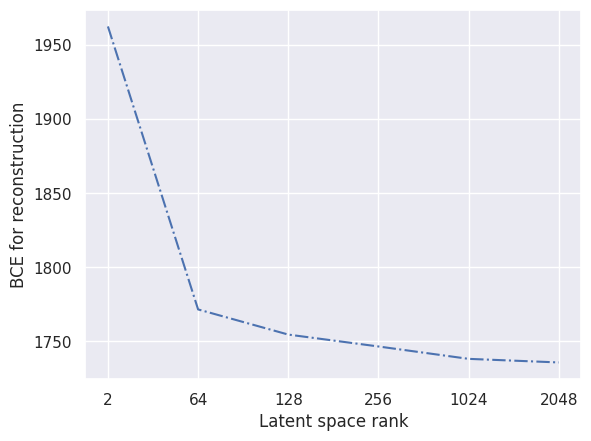

In [8]:
mse_dev = [min(batch['dev_loss']) for batch in histories]
fig, ax = plt.subplots()

ax.plot(mse_dev, label='train', c='b', linestyle="-.")
ax.set_ylabel('BCE for reconstruction')
ax.set_xlabel('Latent space rank')

ax.set_xticks(np.arange(len(mse_dev)))
ax.set_xticklabels(ranks)
 
plt.show()

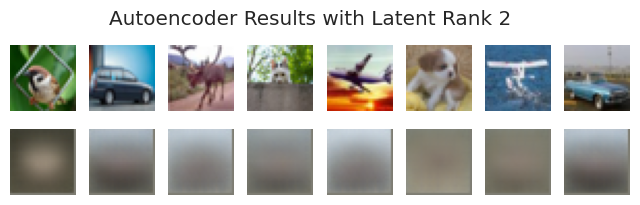

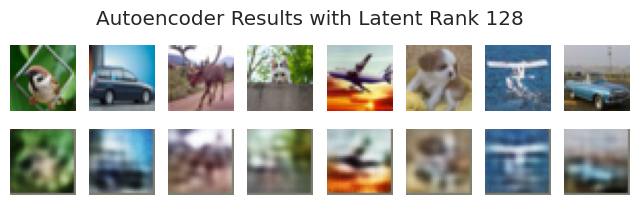

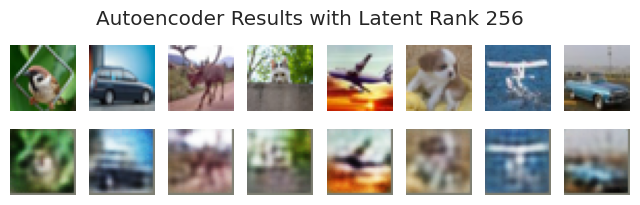

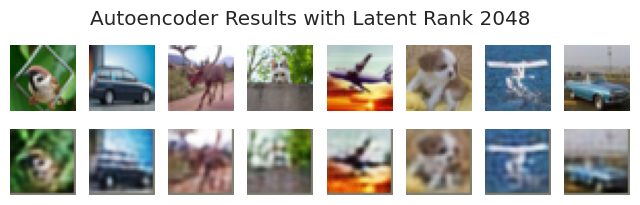

In [11]:
sample = next(iter(test_loader))[0][np.random.choice(test_loader.batch_size, size=8)]

for rank in [2, 128, 256, 2048]:
    
    model = Autoencoder(input_depth=3, hidden_dim=rank)
    model.load(Path(output) / f'best_model_{rank}.pt')

    autoencode = model(sample.to(model.device))[3].detach().cpu().numpy()
    sample_plot = np.concatenate([sample.detach().cpu().numpy(), autoencode], axis=0)
    
    fig, axs = plt.subplots(2, 8, figsize=(8, 2))
    fig.suptitle(f'Autoencoder Results with Latent Rank {rank}', y=1.05)

    for i in range(2):
        for j in range(8): 
            ax = axs[i, j] 
            ax.imshow(sample_plot[8*i + j].transpose(1, 2, 0))
            ax.axis('off')

    plt.show()

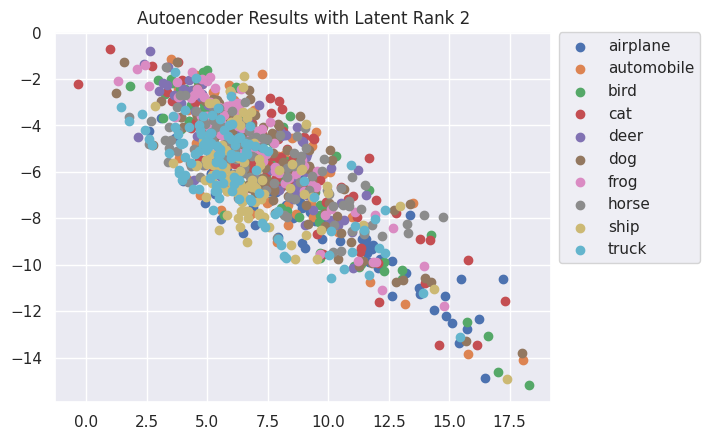

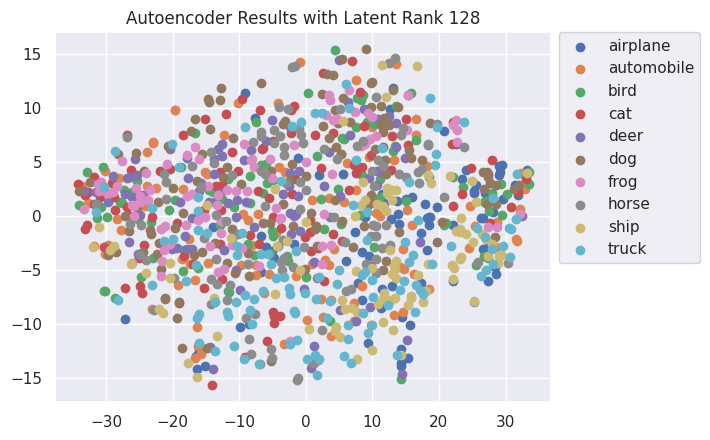

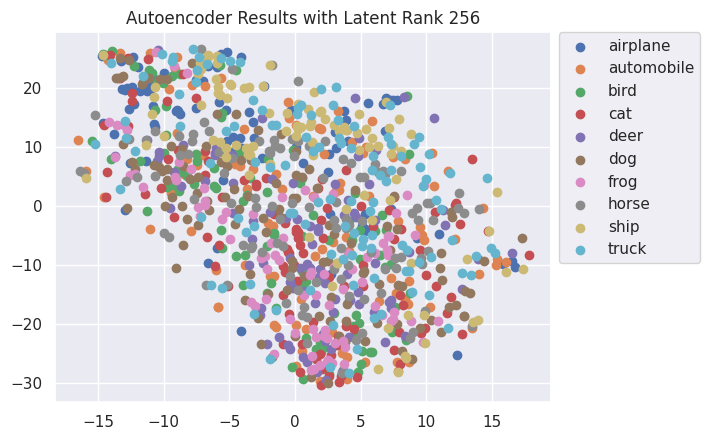

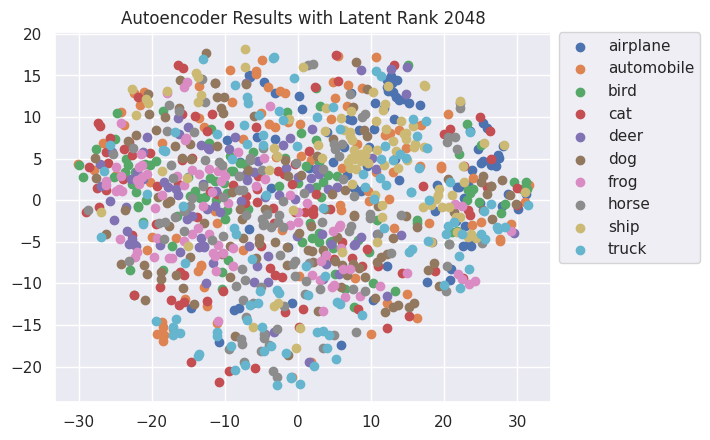

In [12]:
for rank in [2, 128, 256, 2048]:

    model = Autoencoder(input_depth=3, hidden_dim=rank)
    model.load(Path(output) / f'best_model_{rank}.pt')
    plot_projection(loader = test_loader, n_components = 2, model = model, source = f'Autoencoder Results with Latent Rank {rank}', reduction = 'tsne' )
    
    

Evaluation of compact representation in terms of cluser quality metrics in a high-dimensional space.

The Silhouette Coefficient for a sample x is defined as:

$\mathcal{F}(x) = \frac{(b - a)}{max(a, b)}$.

Where a is the mean intra-cluster distance, and b is the mean nearest-cluster distance.

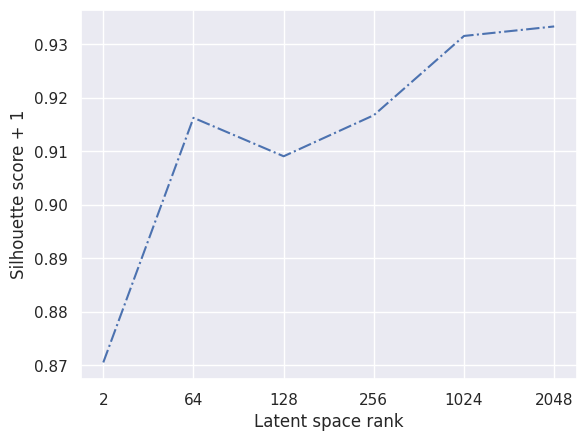

In [8]:
ranks = [2, 64, 128, 256, 1024, 2048] #remove
output = 'logs_vae' #remove

metric = []
per_sample_metric = []
for rank in ranks:

    label, example = [], []
    model = Autoencoder(input_depth=3, hidden_dim=rank)
    model.load(Path(output) / f'best_model_{rank}.pt')

    for images, labels in test_loader:
        
        label += [labels.numpy()]
        
        encoding = model(images.to(model.device), get_encoding=True).detach().cpu()
        example += [encoding.numpy()]

    example = np.concatenate(example, axis=0)
    label = np.concatenate(label)

    metric += [silhouette_score(example, label) + 1]
    per_sample_metric += [silhouette_samples(example, label, metric='euclidean')]

fig, ax = plt.subplots()

ax.plot(metric, label='train', c='b', linestyle="-.")
ax.set_ylabel('Silhouette score + 1')
ax.set_xlabel('Latent space rank')

ax.set_xticks(np.arange(len(metric)))
ax.set_xticklabels(ranks)
 
plt.show()

Silhouette Score per sample

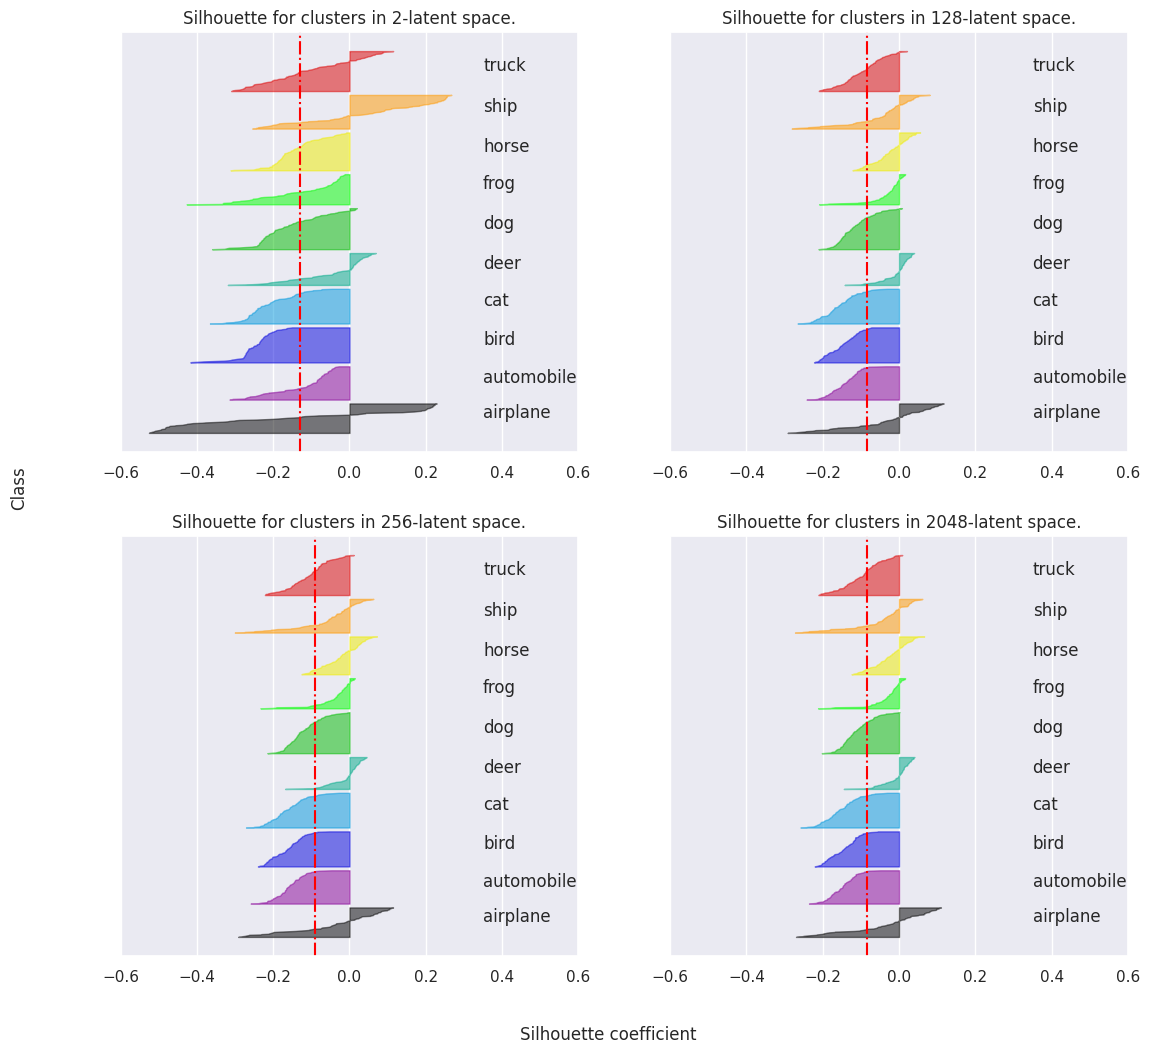

In [21]:
y_lower = 10
fig, ax = plt.subplots(2, 2,figsize=(13, 12))

for order, rank in enumerate([2, 128, 256, 2048]):

    for i in range(len(class_mapping)):
        
        ith_cluster_silhouette_values = per_sample_metric[order][label == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(class_mapping))

        ax[order//2][order%2].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.5,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax[order//2][order%2].text(0.35, y_lower + 0.5 * size_cluster_i, class_mapping[i])

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[order//2][order%2].set_title(f"Silhouette for clusters in {rank}-latent space.")

    # The vertical line for average silhouette score of all the values
    ax[order//2][order%2].axvline(x=metric[order] - 1, color="red", linestyle="-.")

    ax[order//2][order%2].set_yticks([])  # Clear the yaxis labels / ticks
    ax[order//2][order%2].set_xticks([ -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])


fig.text(0.5, 0.04, 'Silhouette coefficient', ha='center')
fig.text(0.04, 0.5, 'Class', va='center', rotation='vertical')

plt.show()



In [ ]:
# https://github.com/labadier/CV-Project-Resnet.git
from DiscriminativeModel import ResNet, train_model, load_dataset as load_discriminative_dataset


ep = 24
bs = 256
lr = 1e-2
output_discriminative = 'out'

Path(output_discriminative).mkdir(parents=True, exist_ok=True)
trainloader, devloader = load_discriminative_dataset(bs)

history, lr_history = train_model(trainloader, devloader, epoches = ep, batch_size = bs, lr = lr, output=os.path.join(output_discriminative, 'best_model'))
model = ResNet()
model.load(Path(output_discriminative) / f'best_model')


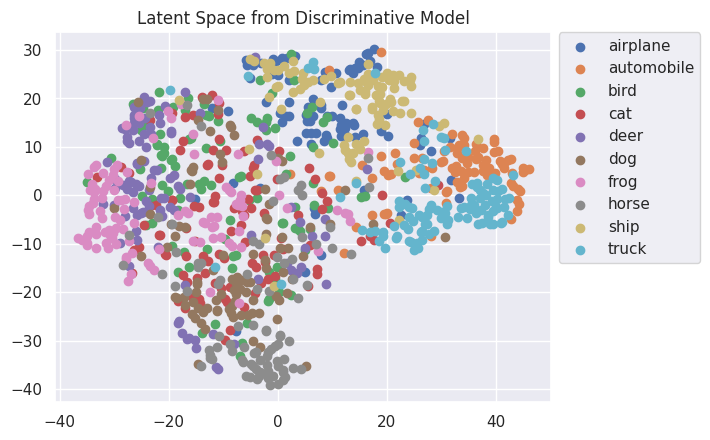

In [ ]:
plot_projection(loader = test_loader, n_components = 2, model = model, source = f'Latent Space from Discriminative Model', reduction = 'tsne' )